In [ ]:
import os
import librosa
import soundfile as sf
from pydub import AudioSegment
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
import warnings
warnings.filterwarnings("ignore")
import os
import csv
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2Processor
import random
import shutil
INPUT_DIR = "dataset_raw"
OUTPUT_DIR = "dataset"
classes = ["normal", "articulation", "stuttering"]
DATA_DIR = "dataset"


# Introduction

## 1. Project Objective
#### The goal of this project is to develop a model capable of automatically classifying speech defects from short audio samples.  

The initial prototype focuses on binary classification of:
- **normal speech**
- **articulation disorders** (e.g., mispronunciations, phonetic deviations)
- **stuttering**, (CLASS / SEP-28k).  

## 2. Datasets Used

For this project we rely on two primary sources:

### 1. Articulation Disorders Dataset  
Contains recordings of subjects with various articulation impairments.  
Directory example:

`dataset_raw/articulation/M05/Session1/wav_arrayMic/0001.wav`

### 2. Normal Speech Dataset (LibriSpeech Subset)
Contains clean speech samples from speakers without speech impairments.  
Directory example:

`dataset_raw/normal/dev-clean/batch1/1993/147964/1993-147964-0000.wav`

### 3. Stuttering Speech: SEP-28k dataset
Capturing temporal irregularities and disfluencies.
Each dataset had its own format and structure.

Directory example:

`dataset_raw/stuttering/WomenWhoStutter/WomenWhoStutter_97_15.wav`

# Dataset Exploration
## Printing directory structure

In [ ]:
for root, dirs, files in os.walk(INPUT_DIR):
    print(root)
    print(" Subdirectories:", dirs)
    break  # printing only top-level

dataset_raw
 Subdirectories: ['stuttering', 'articulation', 'normal']


## Loading and displaying waveform

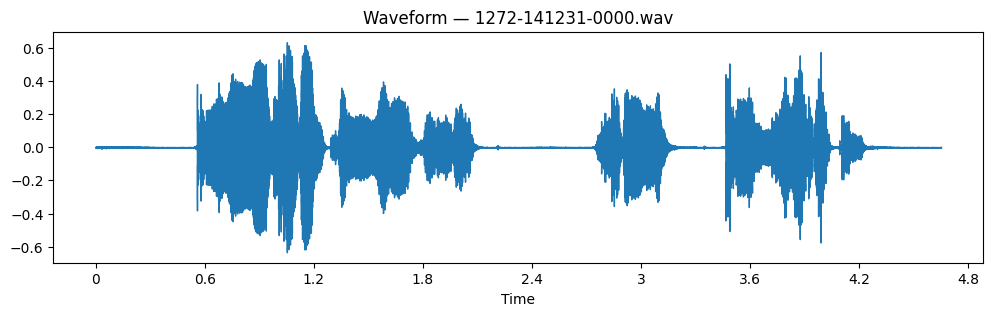

Sampling rate: 16000
Duration (sec): 4.65


In [ ]:
sample_path = "dataset_raw/normal/dev-clean/1272/141231/1272-141231-0000.wav"

audio, sr = librosa.load(sample_path, sr=None, mono=True)

plt.figure(figsize=(12, 3))
librosa.display.waveshow(audio, sr=sr)
plt.title(f"Waveform — {os.path.basename(sample_path)}")
plt.show()

print("Sampling rate:", sr)
print("Duration (sec):", len(audio) / sr)

## Playing audio sample

In [ ]:
Audio(sample_path)

# Data Preprocessing
## Converting to mono and resampling (16 kHz)

In [ ]:
def load_audio(path, target_sr=16000):
    try:
        audio, sr = librosa.load(path, sr=target_sr, mono=True)
        return audio, target_sr
    except Exception as e:
        return None, None

## RMS normalization

In [ ]:
def normalize_audio(audio, eps=1e-6):
    rms = np.sqrt(np.mean(audio**2) + eps)
    target_rms = 0.03
    return audio * (target_rms / rms)

## Cutting into 3-5 second Chunks

In [ ]:
def split_audio(audio, sr, label, min_sec=3, max_sec=5):
    min_len = min_sec * sr
    max_len = max_sec * sr

    if label == "articulation":
        chunks = []
        chunk_len = max_len
        for start in range(0, len(audio), chunk_len):
            chunk = audio[start:start + chunk_len]
            if len(chunk) < min_len:
                continue
            chunks.append(chunk)
        return chunks
    chunks = []
    chunk_len = max_len

    for start in range(0, len(audio), chunk_len):
        chunk = audio[start:start + chunk_len]

        if len(chunk) < min_len:
            continue

        chunks.append(chunk)

    return chunks

## Single file processing function

In [ ]:
def process_file(input_path, output_dir, label, errors_log):
    audio, sr = load_audio(input_path)

    if audio is None:
        errors_log.append(f"Failed to load: {input_path}")
        return

    audio = normalize_audio(audio)

    chunks = split_audio(audio, sr, label)

    if len(chunks) == 0:
        errors_log.append(f"No suitable chunks: {input_path}")
        return

    # creating directory
    class_dir = os.path.join(output_dir, label)
    os.makedirs(class_dir, exist_ok=True)

    base_name = os.path.splitext(os.path.basename(input_path))[0]
    # saving chunks
    for idx, chunk in enumerate(chunks):
        out_path = os.path.join(class_dir, f"{base_name}_{idx}.wav")
        sf.write(out_path, chunk, sr)

## Main function for preprocessing

In [ ]:
def preprocess_dataset(input_root, output_root):
    errors = []
    for label in classes:
        input_path = os.path.join(input_root, label)

        if not os.path.exists(input_path):
            print(f"Missing folder: {input_path}")
            continue

        # recursively traversing all subfolders
        for root, dirs, files in os.walk(input_path):
            wav_files = [f for f in files if f.lower().endswith(".wav")]

            for fname in tqdm(wav_files, desc=f"Processing {label}"):
                full_path = os.path.join(root, fname)
                process_file(full_path, output_root, label, errors)

    return errors

errors = preprocess_dataset(INPUT_DIR, OUTPUT_DIR)

Processing normal: 0it [00:00, ?it/s]
Processing normal: 0it [00:00, ?it/s]
Processing normal: 0it [00:00, ?it/s]
Processing normal: 100%|██████████| 16/16 [00:00<00:00, 355.27it/s]
Processing normal: 0it [00:00, ?it/s]
Processing normal: 100%|██████████| 52/52 [00:00<00:00, 341.60it/s]
Processing normal: 0it [00:00, ?it/s]
Processing normal: 100%|██████████| 16/16 [00:00<00:00, 280.99it/s]
Processing normal: 0it [00:00, ?it/s]
Processing normal: 100%|██████████| 64/64 [00:00<00:00, 400.34it/s]
Processing normal: 0it [00:00, ?it/s]
Processing normal: 100%|██████████| 36/36 [00:00<00:00, 231.79it/s]
Processing normal: 0it [00:00, ?it/s]
Processing normal: 100%|██████████| 47/47 [00:00<00:00, 296.95it/s]
Processing normal: 0it [00:00, ?it/s]
Processing normal: 100%|██████████| 31/31 [00:00<00:00, 306.06it/s]
Processing normal: 0it [00:00, ?it/s]
Processing normal: 100%|██████████| 27/27 [00:00<00:00, 525.56it/s]
Processing normal: 0it [00:00, ?it/s]
Processing normal: 100%|██████████| 16

## Saving error logs

In [ ]:
with open("prep_errors.log", "w") as f:
    for e in errors:
        f.write(e + "\n")

print("Errors logged to prep_errors.log")

Errors logged to prep_errors.log


## Inspecting number of files per class

In [ ]:
def count_audio_files(path):
    count = 0
    for root, dirs, files in os.walk(path):
        count += len([f for f in files if f.lower().endswith(".wav")])
    return count

normal_count = count_audio_files(os.path.join(OUTPUT_DIR, "normal"))
articulation_count = count_audio_files(os.path.join(OUTPUT_DIR, "articulation"))
stuttering_count = count_audio_files(os.path.join(OUTPUT_DIR, "stuttering"))

print("Normal speech files:", normal_count)
print("Articulation disorder files:", articulation_count)
print("Stuttering files:", stuttering_count)

Normal speech files: 2092
Articulation disorder files: 316
Stuttering files: 1517


## Balancing Dataset

In [ ]:
target_count = articulation_count  # 316 файлов

for label in ["normal", "stuttering"]:
    class_dir = os.path.join(OUTPUT_DIR, label)
    all_files = [f for f in os.listdir(class_dir) if f.endswith(".wav")]

    if len(all_files) > target_count:
        to_remove = random.sample(all_files, len(all_files) - target_count)
        for f in to_remove:
            os.remove(os.path.join(class_dir, f))

# Проверка
normal_count = count_audio_files(os.path.join(OUTPUT_DIR, "normal"))
stuttering_count = count_audio_files(os.path.join(OUTPUT_DIR, "stuttering"))
print("Balanced counts:")
print("Normal speech files:", normal_count)
print("Articulation disorder files:", articulation_count)
print("Stuttering files:", stuttering_count)

Balanced counts:
Normal speech files: 316
Articulation disorder files: 316
Stuttering files: 316


# Dataset CSV

In [ ]:
data = []
for label in classes:
    class_dir = os.path.join(DATA_DIR, label)
    if not os.path.exists(class_dir):
        continue
    for f in os.listdir(class_dir):
        if f.endswith(".wav"):
            path = os.path.join(class_dir, f)
            data.append([path, label])

df = pd.DataFrame(data, columns=["path", "label"])

train_val, test = train_test_split(df, test_size=0.1, random_state=42, stratify=df["label"])
train, val = train_test_split(train_val, test_size=0.1111, random_state=42, stratify=train_val["label"])  # 10%

train.to_csv("train.csv", index=False)
val.to_csv("val.csv", index=False)
test.to_csv("test.csv", index=False)

print("CSV files: train.csv, val.csv, test.csv")


CSV files: train.csv, val.csv, test.csv


# Imports

In [ ]:
import os
import librosa
import soundfile as sf
from pydub import AudioSegment
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import Audio
import warnings
warnings.filterwarnings("ignore")
import csv
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2Processor, Wav2Vec2Model
import torch.nn as nn
from torch.optim import AdamW
import seaborn as sns
import numpy as np
import random
from google.colab import drive
from torchaudio.transforms import FrequencyMasking, TimeMasking
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Path changes for Google Colab

In [ ]:
DATASET_DIR = "/content/drive/MyDrive/data/dataset"

old_csv_path = "/content/drive/MyDrive/data/train.csv"
new_csv_path = "/content/drive/MyDrive/data/dataset/train_fixed.csv"

df = pd.read_csv(old_csv_path)

def fix_path(old_path):
    file_name = os.path.basename(old_path)
    if "normal" in old_path.lower():
        label = "normal"
    elif "articulation" in old_path.lower():
        label = "articulation"
    elif "stuttering" in old_path.lower():
        label = "stuttering"
    else:
        raise ValueError(f"can't define path for {old_path}")

    return os.path.join(DATASET_DIR, label, file_name)

df["path"] = df["path"].apply(fix_path)

df.to_csv(new_csv_path, index=False)
print("fixed CSV:", new_csv_path)

fixed CSV: /content/drive/MyDrive/data/dataset/train_fixed.csv


In [ ]:
DATASET_DIR = "/content/drive/MyDrive/data/dataset"

old_csv_path = "/content/drive/MyDrive/data/val.csv"
new_csv_path = "/content/drive/MyDrive/data/dataset/val_fixed.csv"

df = pd.read_csv(old_csv_path)

def fix_path(old_path):
    file_name = os.path.basename(old_path)
    if "normal" in old_path.lower():
        label = "normal"
    elif "articulation" in old_path.lower():
        label = "articulation"
    elif "stuttering" in old_path.lower():
        label = "stuttering"
    else:
        raise ValueError(f"can't define path for {old_path}")

    return os.path.join(DATASET_DIR, label, file_name)

df["path"] = df["path"].apply(fix_path)

df.to_csv(new_csv_path, index=False)
print("fixed CSV:", new_csv_path)

fixed CSV: /content/drive/MyDrive/data/dataset/val_fixed.csv


# Data Loader

## Loader preporation

In [ ]:
# innitialization
processor = Wav2Vec2Processor.from_pretrained(
    "facebook/wav2vec2-base-960h"
)

preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

## Dataset class

In [ ]:
LABEL2ID = {
    "normal": 0,
    "articulation": 1,
    "stuttering": 2
}

ID2LABEL = {v: k for k, v in LABEL2ID.items()}
num_classes = 3

class AudioDataset(Dataset):
    def __init__(
        self,
        csv_path,
        processor,
        target_sr=16000,
        augment=False,
        max_duration_sec=10
    ):
        self.df = pd.read_csv(csv_path)
        self.processor = processor
        self.target_sr = target_sr
        self.augment = augment
        self.max_samples = target_sr * max_duration_sec

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        audio = np.zeros(16000, dtype=np.float32)
        row = self.df.iloc[idx]
        path = row["path"]
        label = LABEL2ID[row["label"]]

        # load audio
        audio, sr = sf.read(path)
        if audio.ndim > 1:
            audio = audio.mean(axis=1)

        if sr != self.target_sr:
            audio = librosa.resample(audio, orig_sr=sr, target_sr=self.target_sr)

        audio = audio.astype(np.float32)

        # hard cut (important for memory)
        if len(audio) > self.max_samples:
            audio = audio[: self.max_samples]

        # simple augmentation
        if self.augment and np.random.rand() < 0.3:
            noise = np.random.randn(len(audio)) * 0.003
            audio = audio + noise

        return {
            "input_values": audio,
            "labels": torch.tensor(label, dtype=torch.long)
        }

## Loading Data

In [ ]:
TRAIN_CSV = "/content/drive/MyDrive/data/dataset/train_fixed.csv"
VAL_CSV   = "/content/drive/MyDrive/data/dataset/val_fixed.csv"

train_dataset = AudioDataset(TRAIN_CSV , processor, augment=True)
val_dataset   = AudioDataset(VAL_CSV , processor, augment=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Class weights
train_df = pd.read_csv(TRAIN_CSV)

class_counts = train_df["label"].value_counts()
print("Class counts:\n", class_counts)

weights = 1.0 / class_counts
weights = weights / weights.sum()

class_weights = torch.tensor(
    [
        weights["normal"],
        weights["articulation"],
        weights["stuttering"]
    ],
    dtype=torch.float
).to(device)

print("Class weights:", class_weights)


def collate_fn(batch):
    audios = [item["input_values"] for item in batch]
    labels = torch.stack([item["labels"] for item in batch])

    batch = processor(
        audios,
        sampling_rate=16000,
        padding=True,
        return_tensors="pt",
        return_attention_mask=True
    )

    batch["labels"] = labels
    return batch

train_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=0,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=0,
    pin_memory=True
)

Class counts:
 label
stuttering      253
articulation    253
normal          252
Name: count, dtype: int64
Class weights: tensor([0.3342, 0.3329, 0.3329], device='cuda:0')


In [ ]:
batch = next(iter(train_loader))

print("input_values:", batch["input_values"].shape)
print("attention_mask:", batch["attention_mask"].shape)
print("labels:", batch["labels"])

input_values: torch.Size([4, 80000])
attention_mask: torch.Size([4, 80000])
labels: tensor([0, 1, 2, 2])


# Model Training

## Defining a model with classification head

In [ ]:
class Wav2Vec2Classifier(nn.Module):
    def __init__(self, base_model_name="facebook/wav2vec2-base-960h", num_classes=3):
        super().__init__()
        self.wav2vec2 = Wav2Vec2Model.from_pretrained(base_model_name)

        total_layers = len(list(self.wav2vec2.encoder.layers))
        # freezing 90% of the layers
        freeze_layers = int(total_layers * 0.9)
        for i, layer in enumerate(self.wav2vec2.encoder.layers):
            if i < freeze_layers:
                for param in layer.parameters():
                    param.requires_grad = False
        # classifier head
        self.classifier = nn.Linear(self.wav2vec2.config.hidden_size, num_classes)
    def forward(self, input_values, attention_mask):
        outputs = self.wav2vec2(
          input_values=input_values,
          attention_mask=attention_mask
          )
        hidden_states = outputs.last_hidden_state  # [B, T, H]
          # downsample attention mask
        mask = self.wav2vec2._get_feature_vector_attention_mask(
          hidden_states.shape[1],
          attention_mask
          )  # [B, T]
        mask = mask.unsqueeze(-1).float()          # [B, T, 1]
        summed = (hidden_states * mask).sum(dim=1)
        counts = mask.sum(dim=1).clamp(min=1e-9)
        pooled = summed / counts
        logits = self.classifier(pooled)
        return logits

# initialization of the model, optimizer, and loss
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Wav2Vec2Classifier().to(device)

optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)
criterion = nn.CrossEntropyLoss(weight=class_weights)



model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Function for one epoch

In [ ]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in tqdm(loader):
        input_values = batch["input_values"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        logits = model(input_values, attention_mask)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return total_loss / len(loader), correct / total


def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in loader:
            input_values = batch["input_values"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            logits = model(input_values, attention_mask)
            loss = criterion(logits, labels)

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return total_loss / len(loader), correct / total

## Training our model

In [ ]:
# adding early stopping
num_epochs = 10
patience = 3
best_val_loss = float("inf")
epochs_no_improve = 0
train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f}, Val   Acc: {val_acc:.4f}")

    # early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_wav2vec2_model_3.pt")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

100%|██████████| 190/190 [13:32<00:00,  4.28s/it]


Epoch 1/10
Train Loss: 1.0501, Train Acc: 0.4868
Val   Loss: 0.9295, Val   Acc: 0.4947


100%|██████████| 190/190 [00:54<00:00,  3.46it/s]


Epoch 2/10
Train Loss: 0.7838, Train Acc: 0.6596
Val   Loss: 0.6767, Val   Acc: 0.5895


100%|██████████| 190/190 [00:55<00:00,  3.42it/s]


Epoch 3/10
Train Loss: 0.5876, Train Acc: 0.7691
Val   Loss: 0.5275, Val   Acc: 0.8000


100%|██████████| 190/190 [00:53<00:00,  3.55it/s]


Epoch 4/10
Train Loss: 0.4016, Train Acc: 0.8813
Val   Loss: 0.2454, Val   Acc: 0.9263


100%|██████████| 190/190 [00:53<00:00,  3.54it/s]


Epoch 5/10
Train Loss: 0.3144, Train Acc: 0.9011
Val   Loss: 0.6140, Val   Acc: 0.7263


100%|██████████| 190/190 [00:54<00:00,  3.51it/s]


Epoch 6/10
Train Loss: 0.2384, Train Acc: 0.9459
Val   Loss: 0.2834, Val   Acc: 0.8947


100%|██████████| 190/190 [00:53<00:00,  3.55it/s]


Epoch 7/10
Train Loss: 0.1893, Train Acc: 0.9578
Val   Loss: 0.1668, Val   Acc: 0.9474


100%|██████████| 190/190 [00:53<00:00,  3.53it/s]


Epoch 8/10
Train Loss: 0.1428, Train Acc: 0.9723
Val   Loss: 0.2457, Val   Acc: 0.9158


100%|██████████| 190/190 [00:54<00:00,  3.52it/s]


Epoch 9/10
Train Loss: 0.1245, Train Acc: 0.9736
Val   Loss: 0.4882, Val   Acc: 0.8421


100%|██████████| 190/190 [00:54<00:00,  3.51it/s]


Epoch 10/10
Train Loss: 0.1230, Train Acc: 0.9657
Val   Loss: 0.1001, Val   Acc: 0.9684


# Evaluation

## Plot Metrics

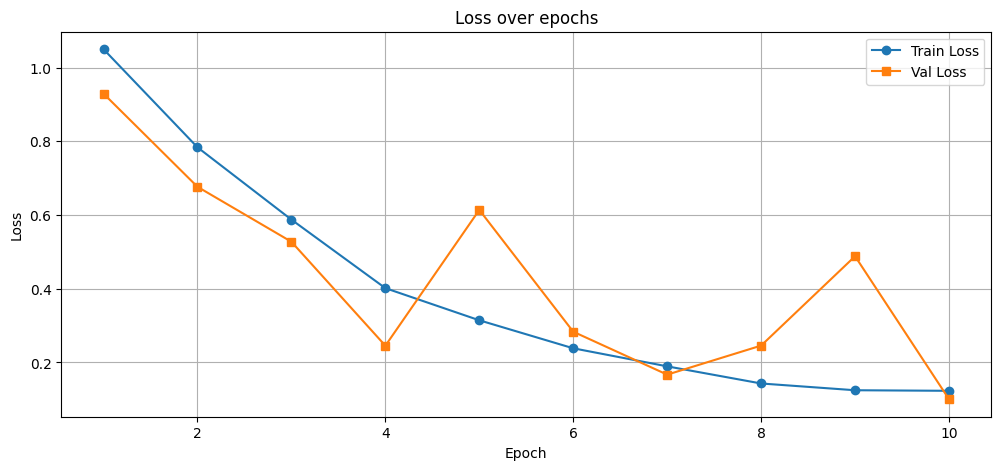

In [ ]:
epochs_range = range(1, len(train_losses)+1)

plt.figure(figsize=(12,5))

# Loss plot
plt.plot(epochs_range, train_losses, 'o-', label='Train Loss')
plt.plot(epochs_range, val_losses, 's-', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.legend()
plt.grid(True)

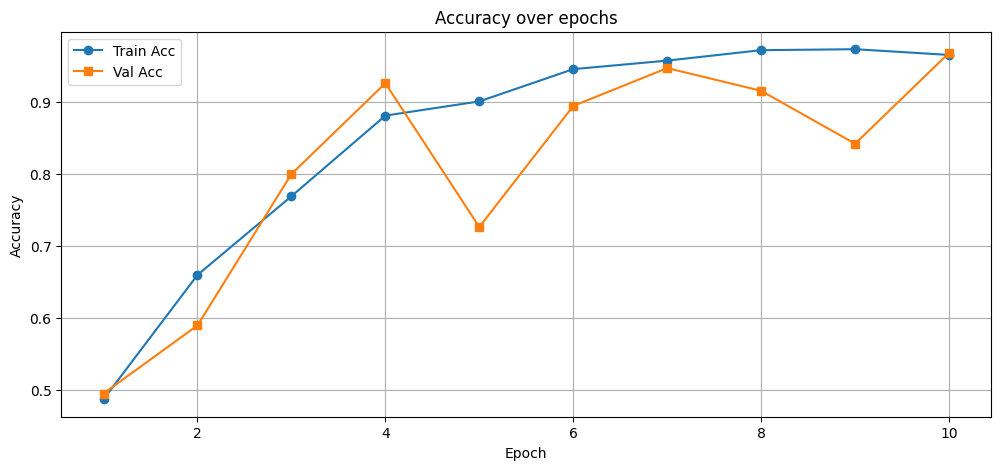

In [ ]:

plt.figure(figsize=(12,5))
# Accuracy plot
plt.plot(epochs_range, train_accs, 'o-', label='Train Acc')
plt.plot(epochs_range, val_accs, 's-', label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over epochs')
plt.legend()
plt.grid(True)

plt.show()

## Loading Test Dataset

In [ ]:
old_csv_path = "/content/drive/MyDrive/data/test.csv"
new_csv_path = "/content/drive/MyDrive/data/dataset/test_fixed.csv"

df = pd.read_csv(old_csv_path)

def fix_path(old_path):
    file_name = os.path.basename(old_path)
    if "normal" in old_path.lower():
        label = "normal"
    elif "articulation" in old_path.lower():
        label = "articulation"
    elif "stuttering" in old_path.lower():
        label = "stuttering"
    else:
        raise ValueError(f"can't define path for {old_path}")

    return os.path.join(DATASET_DIR, label, file_name)

df["path"] = df["path"].apply(fix_path)

df.to_csv(new_csv_path, index=False)
print("fixed CSV:", new_csv_path)

fixed CSV: /content/drive/MyDrive/data/dataset/test_fixed.csv


In [ ]:
TEST_CSV = "/content/drive/MyDrive/data/dataset/test_fixed.csv"
test_dataset = AudioDataset(TEST_CSV, processor, augment=False)
test_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=0,
    pin_memory=True
)

## Evaluating on Train, Val, and Test

In [ ]:
train_loss, train_acc = evaluate(model, train_loader, criterion, device)
val_loss, val_acc = evaluate(model, val_loader, criterion, device)
test_loss, test_acc = evaluate(model, test_loader, criterion, device)

print(f"Final Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
print(f"Final Val   Loss: {val_loss:.4f}, Val   Acc: {val_acc:.4f}")
print(f"Final Test  Loss: {test_loss:.4f}, Test  Acc: {test_acc:.4f}")

Final Train Loss: 0.1166, Train Acc: 0.9657
Final Val   Loss: 0.1001, Val   Acc: 0.9684
Final Test  Loss: 0.1956, Test  Acc: 0.9263


## Get predictions function

In [ ]:
def get_predictions(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in loader:
            input_values = batch["input_values"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            logits = model(input_values, attention_mask)
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

test_preds, test_labels = get_predictions(model, test_loader, device)

## Confusion Matrix

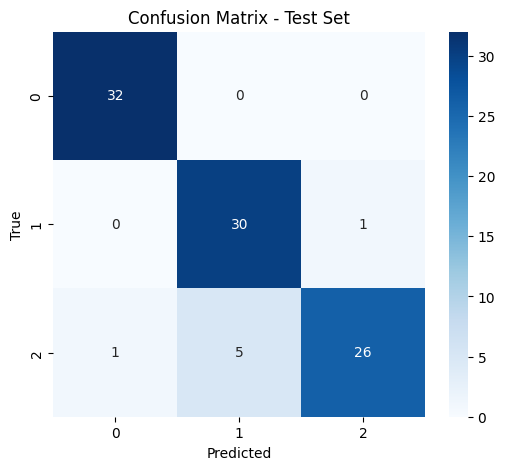

In [ ]:
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Test Set")
plt.show()

## F1, precision, recall

In [ ]:
report = classification_report(test_labels, test_preds, digits=4)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0     0.9697    1.0000    0.9846        32
           1     0.8571    0.9677    0.9091        31
           2     0.9630    0.8125    0.8814        32

    accuracy                         0.9263        95
   macro avg     0.9299    0.9267    0.9250        95
weighted avg     0.9307    0.9263    0.9252        95



In [ ]:
macro_f1 = f1_score(test_labels, test_preds, average="macro")
weighted_f1 = f1_score(test_labels, test_preds, average="weighted")

print(f"Macro F1-score: {macro_f1:.4f}")
print(f"Weighted F1-score: {weighted_f1:.4f}")

Macro F1-score: 0.9250
Weighted F1-score: 0.9252


## Visualization of predictions

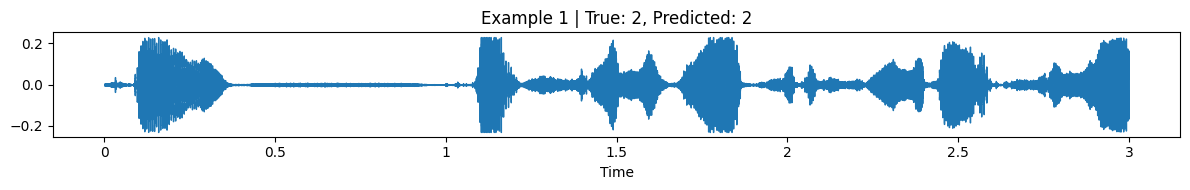

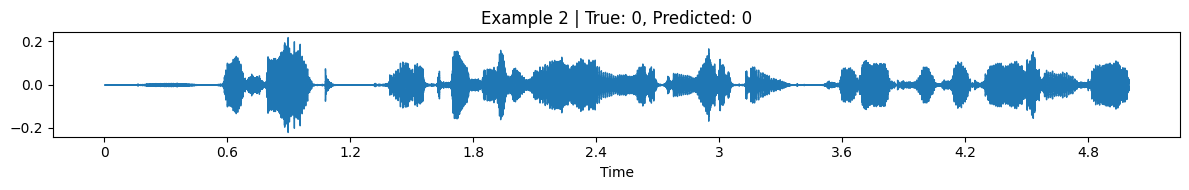

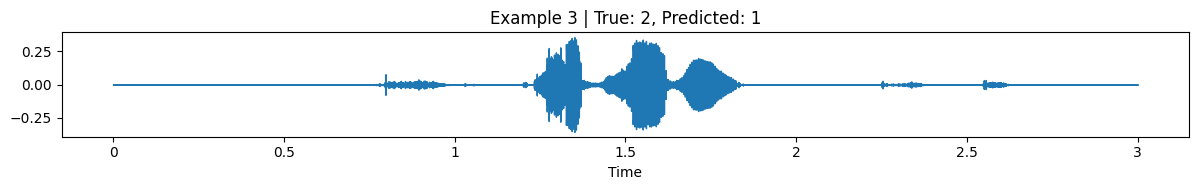

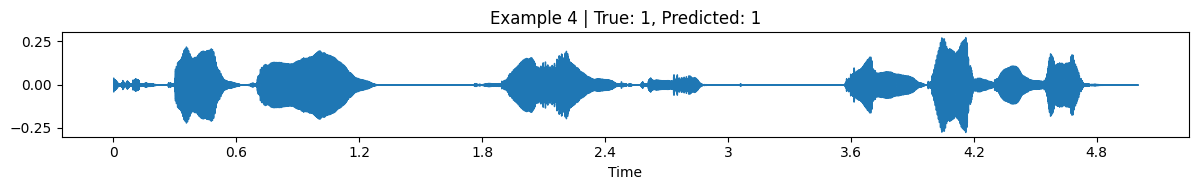

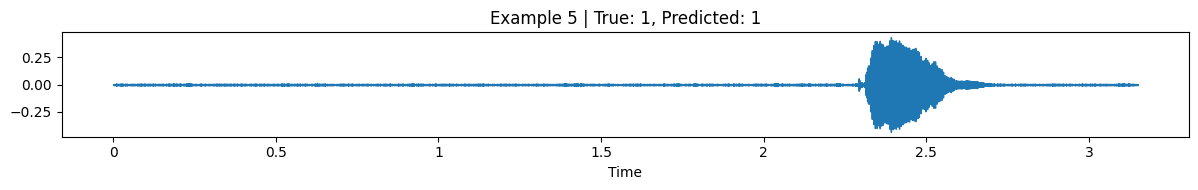

In [ ]:
num_examples = 5
random_indices = random.sample(range(len(test_dataset)), num_examples)
for i, idx in enumerate(random_indices):
    item = test_dataset[idx]
    audio = item["input_values"].cpu().numpy() if isinstance(item["input_values"], torch.Tensor) else item["input_values"]
    true_label = item["labels"].item() if isinstance(item["labels"], torch.Tensor) else item["labels"]
    pred_label = test_preds[idx]

    plt.figure(figsize=(12, 2))
    librosa.display.waveshow(audio, sr=16000)
    plt.title(f"Example {i+1} | True: {true_label}, Predicted: {pred_label}")
    plt.tight_layout()
    plt.show()